In [1]:
from HeaderP import *
import pynbody as pb
import pynbody.filt as filt
import os, pickle, glob


In [2]:
pd.__version__

'1.3.4'

In [3]:
def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./g'+simNo+'_z_0.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    if disk:
        data = data.loc[(data['decomp']==1)|(data['decomp']==4)].reset_index()
    return data


import matplotlib
from scipy import interpolate
from scipy.interpolate import interp1d
def getcolor(vrange,cm=plt.cm.get_cmap('viridis')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange[:-1]), vmax=max(vrange[:-1]))
    return [cmap(norm(i)) for i in vrange]

In [4]:
import os 
sims = os.listdir('./')
sims = [i for i in sims if 'x' in i]
sims = [i for i in sims if '.txt' not in i]
sims = [i for i in sims if '.pkl' not in i]
simsnames = [i.split('_')[0][1:] for i in sims]


In [97]:
from os.path import exists

cols = ['iord','r','z','x','y']
cmap = plt.cm.get_cmap('plasma',20)

Rbirth_switch = True

for i in range(len(sims)):
    if sims[i]=='g1.12e12_3x9':
        continue
    print(sims[i])
    simname = sims[i]
    
    allsnaps = glob.glob(sims[i]+'/*.?????')
    
    agepickle = readsimdata(simsnames[i],True, 15, 5)
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    sortage = sorted(allsnaps_time)
    redshifts = np.zeros(len(sortage))
    allages_rs = np.zeros(len(redshifts))
    for j in trange(len(sortage)):
        s = pb.load(snaplookup[sortage[j]])
        h = s.properties['h']
        ages = float(str(s.properties['time']).split(' ')[0])
        allages_rs[j] = ages
    count = 0
            
    for j in trange(len(allages_rs)):
        #print('reading ',snaplookup[sortage[j]])
        if exists(snaplookup[sortage[j]]+'.pkl'):
            this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
            if len(this_snap)==0:
                print('no stars in this snap!')
                continue
        else:
            s = pb.load(snaplookup[sortage[j]])
            h=s.halos()
            try:
                pb.analysis.angmom.faceon(h[1])
            except:
                print('no halo!')
                continue
            s.physical_units()
            sim = h[1]

            stars = sim.s
            if len(stars)==0:
                print('no stars!')
                continue
            
            try:
                stars['iord']
            except:
                print('no IDs!')
                continue
            this_snap = pd.DataFrame({k:stars[k] for k in cols})
            this_snap = pd.merge(this_snap, agepickle[['iord', 'age', 'feh', 'Rbir','zbir']], left_on='iord', right_on='iord', how='inner')
            this_snap.to_pickle(snaplookup[sortage[j]]+'.pkl')
        
        plt.figure(figsize=(10,8))
        plt.title(simsnames[i]+'; Cosmic Time = %.3f'%(allages_rs[j])+' Gyr', fontsize=25)
        if Rbirth_switch:
            plt.hexbin(this_snap['age'], this_snap['Rbir'], C = this_snap['r']-this_snap['Rbir'],
                   extent = (0,14,0,15), gridsize=40, vmin=0, vmax=4, cmap=cmap, reduce_C_function = np.std, mincnt = 20)
        else:
            plt.hexbin(this_snap['age'], this_snap['r'], C = this_snap['r']-this_snap['Rbir'],
                   extent = (0,14,0,15), gridsize=40, vmin=0, vmax=4, cmap=cmap, reduce_C_function = np.std, mincnt = 20)
        plt.xlabel('Age [Gyr]')
        if Rbirth_switch:
            plt.ylabel('$R_{bir}$')
        else:
            plt.ylabel('Current Radius')
        cb = plt.colorbar()
        cb.set_label('$σ_{R-R_{bir}}$ [kpc]')
        plt.tight_layout()
        if Rbirth_switch:
            plt.savefig('RM/'+simsnames[i]+'/'+str(count)+'_Rbir.png')
        else:
            plt.savefig('RM/'+simsnames[i]+'/'+str(count)+'.png')
        plt.xlim([0,14])
        plt.ylim([0,15])
        count = count+1
        plt.close()

g6.96e11_3x9


  1%|          | 1/128 [00:01<02:26,  1.15s/it]

no halo!
no stars in this snap!
no stars in this snap!


 14%|█▍        | 18/128 [00:06<00:37,  2.94it/s]

no stars in this snap!
no stars in this snap!


100%|██████████| 128/128 [01:20<00:00,  1.60it/s]


g8.26e11_2x4x8


  1%|          | 1/180 [00:00<00:58,  3.06it/s]

no halo!


  1%|          | 2/180 [00:21<36:36, 12.34s/it]

no stars!
no stars in this snap!


 19%|█▉        | 34/180 [00:47<10:34,  4.34s/it]

no IDs!


100%|██████████| 180/180 [05:05<00:00,  1.69s/it]


g7.08e11_5x10


  1%|          | 1/160 [00:00<02:15,  1.17it/s]

no halo!
no stars in this snap!
no stars in this snap!
no stars in this snap!
no stars in this snap!


100%|██████████| 160/160 [03:29<00:00,  1.31s/it]


g2.79e12_3x6


  1%|          | 2/229 [00:00<00:32,  6.92it/s]

no halo!
no halo!


  1%|▏         | 3/229 [00:11<19:39,  5.22s/it]

no stars!
no stars in this snap!


100%|██████████| 229/229 [08:55<00:00,  2.34s/it]


g7.55e11_3x9


  1%|          | 1/128 [00:01<03:09,  1.49s/it]

no halo!
no stars in this snap!
no stars in this snap!
no stars in this snap!


100%|██████████| 128/128 [02:26<00:00,  1.14s/it]


In [98]:
from os.path import exists

cols = ['iord','r','z','x','y']
cmap = plt.cm.get_cmap('plasma',20)

for i in range(len(sims)):
    if sims[i]=='g1.12e12_3x9':
        continue
    print(sims[i])
    simname = sims[i]
    
    allsnaps = glob.glob(sims[i]+'/*.?????')
    
    agepickle = readsimdata(simsnames[i],True, 15, 5)
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    sortage = sorted(allsnaps_time)
    redshifts = np.zeros(len(sortage))
    allages_rs = np.zeros(len(redshifts))
    for j in trange(len(sortage)):
        s = pb.load(snaplookup[sortage[j]])
        h = s.properties['h']
        ages = float(str(s.properties['time']).split(' ')[0])
        allages_rs[j] = ages
    count = 0
            
    for j in trange(len(allages_rs)-1):
        try:
            this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
            next_snap = pd.read_pickle(snaplookup[sortage[j+1]]+'.pkl')
            this_snap['age'], next_snap['age']
        except:
            print('no snap!')
            continue

        plt.figure(figsize=(10,8))
        plt.title(simsnames[i]+'; Cosmic Time = %.3f'%(allages_rs[j+1])+' Gyr', fontsize=25)
        
        timediff = allages_rs[j+1]-allages_rs[j]

        output = plt.hexbin(this_snap['age'], this_snap['Rbir'], C = this_snap['r']-this_snap['Rbir'],
               extent = (0,14,0,15), gridsize=20, reduce_C_function = np.std);
        plt.close()
        output_2 = plt.hexbin(next_snap['age'], next_snap['Rbir'], C = next_snap['r']-next_snap['Rbir'],
               extent = (0,14,0,15), gridsize=20, reduce_C_function = np.std);
        plt.close()

        plt.figure(figsize=(10,8))
        plt.title(simsnames[i]+'; Cosmic Time = %.3f'%(allages_rs[j+1])+' Gyr', fontsize=25)
        h3=plt.hexbin(this_snap['age'], this_snap['Rbir'], gridsize=20, cmap=cmap, vmin=-0.5,
                     vmax=0.5, mincnt=1)
        try:
            h3.set_array((output_2.get_array()-output.get_array())/timediff)
        except:
            print('not the same size!')
            continue
        plt.xlabel('Age [Gyr]')
        plt.ylabel('$R_{bir}$') 
        plt.xlim([0,14])
        plt.ylim([0,15])

        cb = plt.colorbar()
        cb.set_label('Δ($σ_{R-R_{bir}}$)/Δτ [kpc/Gyr]')

        plt.tight_layout()
        count = count+1
        
        plt.savefig('RM/'+simsnames[i]+'/'+str(count)+'_Rbir_diff.png')
        plt.close()

g6.96e11_3x9


  0%|          | 0/127 [00:00<?, ?it/s]

no snap!


  4%|▍         | 5/127 [00:00<00:09, 12.73it/s]

not the same size!
not the same size!
not the same size!


  8%|▊         | 10/127 [00:00<00:09, 12.22it/s]

not the same size!
not the same size!
not the same size!
not the same size!
not the same size!


 11%|█         | 14/127 [00:01<00:11, 10.20it/s]

not the same size!
not the same size!


 13%|█▎        | 16/127 [00:02<00:18,  6.02it/s]

not the same size!
not the same size!
not the same size!


 17%|█▋        | 22/127 [00:02<00:12,  8.73it/s]

not the same size!
not the same size!
not the same size!
not the same size!


 22%|██▏       | 28/127 [00:03<00:12,  7.84it/s]

not the same size!
not the same size!
not the same size!
not the same size!


 25%|██▌       | 32/127 [00:03<00:09, 10.19it/s]

not the same size!
not the same size!
not the same size!


 27%|██▋       | 34/127 [00:03<00:08, 10.55it/s]

not the same size!
not the same size!


 28%|██▊       | 36/127 [00:04<00:12,  7.13it/s]

not the same size!
not the same size!


 31%|███▏      | 40/127 [00:05<00:16,  5.41it/s]

not the same size!
not the same size!


 34%|███▍      | 43/127 [00:06<00:16,  5.01it/s]

not the same size!
not the same size!


 36%|███▌      | 46/127 [00:07<00:17,  4.65it/s]

not the same size!
not the same size!


 38%|███▊      | 48/127 [00:07<00:15,  5.01it/s]

not the same size!
not the same size!


 39%|███▊      | 49/127 [00:07<00:15,  4.96it/s]

not the same size!


 39%|███▉      | 50/127 [00:07<00:18,  4.17it/s]

not the same size!


 40%|████      | 51/127 [00:08<00:17,  4.28it/s]

not the same size!


 41%|████      | 52/127 [00:08<00:17,  4.29it/s]

not the same size!


 43%|████▎     | 55/127 [00:09<00:25,  2.83it/s]

not the same size!


 44%|████▍     | 56/127 [00:10<00:23,  3.03it/s]

not the same size!


 46%|████▌     | 58/127 [00:10<00:25,  2.72it/s]

not the same size!


 46%|████▋     | 59/127 [00:11<00:27,  2.49it/s]

not the same size!


 48%|████▊     | 61/127 [00:12<00:36,  1.82it/s]

not the same size!


 49%|████▉     | 62/127 [00:13<00:31,  2.06it/s]

not the same size!


 50%|████▉     | 63/127 [00:13<00:28,  2.27it/s]

not the same size!


 50%|█████     | 64/127 [00:13<00:26,  2.37it/s]

not the same size!


 52%|█████▏    | 66/127 [00:15<00:29,  2.05it/s]

not the same size!


 53%|█████▎    | 67/127 [00:15<00:33,  1.79it/s]

not the same size!


 54%|█████▎    | 68/127 [00:16<00:31,  1.89it/s]

not the same size!


 55%|█████▌    | 70/127 [00:17<00:35,  1.59it/s]

not the same size!


 56%|█████▌    | 71/127 [00:18<00:32,  1.72it/s]

not the same size!


 57%|█████▋    | 72/127 [00:18<00:30,  1.81it/s]

not the same size!


 58%|█████▊    | 74/127 [00:20<00:31,  1.68it/s]

not the same size!


 59%|█████▉    | 75/127 [00:20<00:30,  1.72it/s]

not the same size!


 61%|██████    | 77/127 [00:22<00:36,  1.36it/s]

not the same size!


 61%|██████▏   | 78/127 [00:23<00:34,  1.43it/s]

not the same size!


 62%|██████▏   | 79/127 [00:23<00:32,  1.47it/s]

not the same size!


 63%|██████▎   | 80/127 [00:24<00:31,  1.48it/s]

not the same size!


 64%|██████▍   | 81/127 [00:24<00:30,  1.49it/s]

not the same size!


 65%|██████▍   | 82/127 [00:25<00:31,  1.45it/s]

not the same size!


 65%|██████▌   | 83/127 [00:26<00:32,  1.37it/s]

not the same size!


 67%|██████▋   | 85/127 [00:29<00:45,  1.07s/it]

not the same size!


 68%|██████▊   | 86/127 [00:30<00:44,  1.08s/it]

not the same size!


 69%|██████▊   | 87/127 [00:31<00:43,  1.09s/it]

not the same size!


 69%|██████▉   | 88/127 [00:32<00:39,  1.01s/it]

not the same size!


 70%|███████   | 89/127 [00:33<00:36,  1.05it/s]

not the same size!


 71%|███████   | 90/127 [00:34<00:34,  1.09it/s]

not the same size!


 72%|███████▏  | 91/127 [00:34<00:32,  1.12it/s]

not the same size!


 72%|███████▏  | 92/127 [00:35<00:30,  1.14it/s]

not the same size!


 73%|███████▎  | 93/127 [00:36<00:29,  1.14it/s]

not the same size!


 74%|███████▍  | 94/127 [00:37<00:29,  1.13it/s]

not the same size!


 76%|███████▌  | 96/127 [00:40<00:34,  1.11s/it]

not the same size!


 76%|███████▋  | 97/127 [00:41<00:32,  1.08s/it]

not the same size!


 78%|███████▊  | 99/127 [00:43<00:31,  1.14s/it]

not the same size!


 79%|███████▊  | 100/127 [00:44<00:31,  1.15s/it]

not the same size!


 80%|███████▉  | 101/127 [00:46<00:35,  1.38s/it]

not the same size!


 80%|████████  | 102/127 [00:48<00:36,  1.48s/it]

not the same size!


 82%|████████▏ | 104/127 [00:51<00:36,  1.57s/it]

not the same size!


 83%|████████▎ | 105/127 [00:53<00:32,  1.49s/it]

not the same size!


 83%|████████▎ | 106/127 [00:54<00:30,  1.44s/it]

not the same size!


 85%|████████▌ | 108/127 [00:57<00:30,  1.59s/it]

not the same size!


 86%|████████▌ | 109/127 [00:59<00:28,  1.57s/it]

not the same size!


 88%|████████▊ | 112/127 [01:04<00:25,  1.71s/it]

not the same size!


 89%|████████▉ | 113/127 [01:06<00:24,  1.78s/it]

not the same size!


 91%|█████████ | 115/127 [01:10<00:21,  1.81s/it]

not the same size!


 91%|█████████▏| 116/127 [01:12<00:19,  1.79s/it]

not the same size!


 93%|█████████▎| 118/127 [01:16<00:18,  2.04s/it]

not the same size!


 95%|█████████▌| 121/127 [01:23<00:12,  2.11s/it]

not the same size!


 98%|█████████▊| 124/127 [01:31<00:07,  2.38s/it]

not the same size!


 98%|█████████▊| 125/127 [01:34<00:05,  2.75s/it]

not the same size!


100%|██████████| 127/127 [01:40<00:00,  1.26it/s]

not the same size!
g8.26e11_2x4x8



  3%|▎         | 5/179 [00:00<00:03, 46.95it/s]

no snap!
no snap!
not the same size!
not the same size!
not the same size!
not the same size!
not the same size!
not the same size!


  7%|▋         | 13/179 [00:01<00:14, 11.65it/s]

not the same size!
not the same size!
not the same size!


  9%|▉         | 16/179 [00:01<00:18,  8.97it/s]

not the same size!
not the same size!
not the same size!


 11%|█         | 20/179 [00:01<00:16,  9.73it/s]

not the same size!
not the same size!
not the same size!


 16%|█▌        | 28/179 [00:04<00:41,  3.63it/s]

not the same size!
not the same size!


 16%|█▌        | 29/179 [00:05<00:38,  3.88it/s]

not the same size!


 17%|█▋        | 31/179 [00:05<00:46,  3.19it/s]

not the same size!


 18%|█▊        | 32/179 [00:06<00:44,  3.32it/s]

not the same size!
no snap!
no snap!


 20%|█▉        | 35/179 [00:07<00:44,  3.23it/s]

not the same size!


 20%|██        | 36/179 [00:07<01:00,  2.38it/s]

not the same size!


 21%|██        | 38/179 [00:10<01:33,  1.51it/s]

not the same size!


 23%|██▎       | 41/179 [00:14<02:22,  1.03s/it]

not the same size!


 23%|██▎       | 42/179 [00:15<02:19,  1.02s/it]

not the same size!


 26%|██▌       | 46/179 [00:21<03:03,  1.38s/it]

not the same size!


 27%|██▋       | 48/179 [00:24<02:58,  1.36s/it]

not the same size!


 28%|██▊       | 50/179 [00:27<02:56,  1.37s/it]

not the same size!


 28%|██▊       | 51/179 [00:28<02:53,  1.35s/it]

not the same size!


 29%|██▉       | 52/179 [00:29<03:00,  1.42s/it]

not the same size!


 30%|██▉       | 53/179 [00:31<03:18,  1.58s/it]

not the same size!


 31%|███▏      | 56/179 [00:37<03:46,  1.84s/it]

not the same size!


 32%|███▏      | 58/179 [00:41<03:54,  1.94s/it]

not the same size!


 34%|███▍      | 61/179 [00:47<03:49,  1.94s/it]

not the same size!


 35%|███▍      | 62/179 [00:49<03:46,  1.94s/it]

not the same size!


 36%|███▋      | 65/179 [00:57<04:34,  2.40s/it]

not the same size!


 37%|███▋      | 66/179 [00:59<04:31,  2.40s/it]

not the same size!


 37%|███▋      | 67/179 [01:02<04:36,  2.47s/it]

not the same size!


 38%|███▊      | 68/179 [01:04<04:21,  2.36s/it]

not the same size!


 39%|███▉      | 70/179 [01:09<04:16,  2.35s/it]

not the same size!


 40%|███▉      | 71/179 [01:11<04:10,  2.32s/it]

not the same size!


 41%|████▏     | 74/179 [01:19<04:24,  2.52s/it]

not the same size!


 42%|████▏     | 75/179 [01:21<04:18,  2.48s/it]

not the same size!


 42%|████▏     | 76/179 [01:24<04:16,  2.49s/it]

not the same size!


 45%|████▍     | 80/179 [01:37<05:09,  3.13s/it]

not the same size!


 45%|████▌     | 81/179 [01:40<05:19,  3.26s/it]

not the same size!


 47%|████▋     | 84/179 [01:49<04:50,  3.06s/it]

not the same size!


 47%|████▋     | 85/179 [01:52<04:44,  3.03s/it]

not the same size!


 48%|████▊     | 86/179 [01:55<04:34,  2.95s/it]

not the same size!


 49%|████▉     | 88/179 [02:02<04:43,  3.11s/it]

not the same size!


 50%|█████     | 90/179 [02:08<04:39,  3.14s/it]

not the same size!


 51%|█████     | 91/179 [02:11<04:29,  3.06s/it]

not the same size!


 53%|█████▎    | 95/179 [02:25<04:41,  3.35s/it]

not the same size!


 54%|█████▎    | 96/179 [02:28<04:33,  3.30s/it]

not the same size!


 55%|█████▍    | 98/179 [02:34<04:27,  3.30s/it]

not the same size!


 56%|█████▌    | 100/179 [02:41<04:29,  3.41s/it]

not the same size!


 59%|█████▊    | 105/179 [03:02<04:40,  3.79s/it]

not the same size!


 59%|█████▉    | 106/179 [03:06<04:38,  3.82s/it]

not the same size!


 61%|██████▏   | 110/179 [03:20<04:05,  3.56s/it]

not the same size!


 64%|██████▍   | 115/179 [03:38<03:52,  3.64s/it]

not the same size!


 65%|██████▍   | 116/179 [03:41<03:43,  3.55s/it]

not the same size!


 67%|██████▋   | 120/179 [03:59<04:04,  4.15s/it]

not the same size!


 70%|██████▉   | 125/179 [04:21<03:53,  4.32s/it]

not the same size!


 70%|███████   | 126/179 [04:24<03:36,  4.08s/it]

not the same size!


 71%|███████   | 127/179 [04:29<03:39,  4.22s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 73%|███████▎  | 130/179 [04:41<03:16,  4.00s/it]

not the same size!


 73%|███████▎  | 131/179 [04:44<03:11,  3.99s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 75%|███████▌  | 135/179 [05:03<03:26,  4.70s/it]

not the same size!


 77%|███████▋  | 137/179 [05:12<03:13,  4.60s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 78%|███████▊  | 140/179 [05:27<03:06,  4.78s/it]

not the same size!


 79%|███████▉  | 141/179 [05:31<02:55,  4.62s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 81%|████████  | 145/179 [05:48<02:25,  4.28s/it]

not the same size!


 82%|████████▏ | 146/179 [05:52<02:17,  4.17s/it]

not the same size!


 83%|████████▎ | 148/179 [06:03<02:26,  4.74s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 84%|████████▍ | 150/179 [06:12<02:14,  4.65s/it]

not the same size!


 84%|████████▍ | 151/179 [06:16<02:08,  4.60s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 87%|████████▋ | 155/179 [06:34<01:50,  4.59s/it]

not the same size!


 88%|████████▊ | 158/179 [06:49<01:41,  4.82s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 89%|████████▉ | 160/179 [06:59<01:32,  4.87s/it]

not the same size!


 90%|████████▉ | 161/179 [07:03<01:26,  4.80s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 92%|█████████▏| 165/179 [07:22<01:03,  4.56s/it]

not the same size!


 93%|█████████▎| 166/179 [07:26<00:59,  4.56s/it]

not the same size!


 94%|█████████▍| 168/179 [07:36<00:52,  4.79s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 95%|█████████▍| 170/179 [07:45<00:41,  4.65s/it]

not the same size!


 96%|█████████▌| 171/179 [07:50<00:36,  4.58s/it]

not the same size!


/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 98%|█████████▊| 175/179 [08:12<00:21,  5.50s/it]

not the same size!


 98%|█████████▊| 176/179 [08:16<00:15,  5.11s/it]

not the same size!


 99%|█████████▉| 178/179 [08:26<00:05,  5.02s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
100%|██████████| 179/179 [08:31<00:00,  2.86s/it]


g7.08e11_5x10


  0%|          | 0/159 [00:00<?, ?it/s]

no snap!
no snap!
no snap!


  3%|▎         | 4/159 [00:00<00:12, 12.13it/s]

not the same size!
not the same size!


  4%|▍         | 7/159 [00:00<00:16,  9.31it/s]

not the same size!
not the same size!


  6%|▋         | 10/159 [00:01<00:17,  8.47it/s]

not the same size!


  8%|▊         | 12/159 [00:01<00:20,  7.16it/s]

not the same size!


  9%|▉         | 14/159 [00:01<00:22,  6.44it/s]

not the same size!


 10%|█         | 16/159 [00:02<00:24,  5.96it/s]

not the same size!
not the same size!


 12%|█▏        | 19/159 [00:02<00:21,  6.47it/s]

not the same size!


 13%|█▎        | 21/159 [00:03<00:22,  6.08it/s]

not the same size!


 16%|█▌        | 25/159 [00:03<00:18,  7.09it/s]

not the same size!
not the same size!
not the same size!


 18%|█▊        | 29/159 [00:04<00:17,  7.43it/s]

not the same size!
not the same size!
not the same size!


 20%|██        | 32/159 [00:04<00:19,  6.38it/s]

not the same size!
not the same size!


 21%|██▏       | 34/159 [00:04<00:17,  7.15it/s]

not the same size!


 24%|██▍       | 38/159 [00:06<00:34,  3.55it/s]

not the same size!


 25%|██▌       | 40/159 [00:07<00:37,  3.21it/s]

not the same size!


 26%|██▋       | 42/159 [00:07<00:38,  3.06it/s]

not the same size!


 29%|██▉       | 46/159 [00:09<00:48,  2.34it/s]

not the same size!


 30%|██▉       | 47/159 [00:10<00:43,  2.58it/s]

not the same size!


 32%|███▏      | 51/159 [00:12<00:55,  1.94it/s]

not the same size!


 34%|███▍      | 54/159 [00:14<01:00,  1.74it/s]

not the same size!


 35%|███▌      | 56/159 [00:17<01:41,  1.01it/s]

not the same size!


 36%|███▌      | 57/159 [00:18<01:26,  1.18it/s]

not the same size!


 36%|███▋      | 58/159 [00:18<01:17,  1.31it/s]

not the same size!


 38%|███▊      | 61/159 [00:21<01:18,  1.25it/s]

not the same size!


 39%|███▉      | 62/159 [00:22<01:24,  1.15it/s]

not the same size!


 41%|████      | 65/159 [00:26<02:00,  1.29s/it]

not the same size!


 42%|████▏     | 66/159 [00:28<02:13,  1.43s/it]

not the same size!


 42%|████▏     | 67/159 [00:29<01:58,  1.28s/it]

not the same size!


 43%|████▎     | 68/159 [00:30<01:55,  1.27s/it]

not the same size!


 45%|████▍     | 71/159 [00:33<01:40,  1.14s/it]

not the same size!


 45%|████▌     | 72/159 [00:34<01:36,  1.11s/it]

not the same size!


 47%|████▋     | 75/159 [00:39<02:00,  1.43s/it]

not the same size!


 48%|████▊     | 76/159 [00:41<02:12,  1.59s/it]

not the same size!


 50%|████▉     | 79/159 [00:46<02:06,  1.58s/it]

not the same size!


 50%|█████     | 80/159 [00:48<02:03,  1.56s/it]

not the same size!


 51%|█████     | 81/159 [00:49<02:00,  1.55s/it]

not the same size!


 52%|█████▏    | 82/159 [00:51<02:01,  1.58s/it]

not the same size!


 52%|█████▏    | 83/159 [00:53<02:01,  1.60s/it]

not the same size!


 53%|█████▎    | 84/159 [00:54<02:05,  1.67s/it]

not the same size!


 55%|█████▍    | 87/159 [01:01<02:22,  1.98s/it]

not the same size!


 57%|█████▋    | 90/159 [01:08<02:34,  2.24s/it]

not the same size!


 57%|█████▋    | 91/159 [01:11<02:42,  2.39s/it]

not the same size!


 58%|█████▊    | 93/159 [01:16<02:48,  2.55s/it]

not the same size!


 60%|██████    | 96/159 [01:26<03:02,  2.90s/it]

not the same size!


 62%|██████▏   | 99/159 [01:35<03:02,  3.04s/it]

not the same size!


 63%|██████▎   | 100/159 [01:38<02:58,  3.02s/it]

not the same size!


 64%|██████▍   | 102/159 [01:46<03:19,  3.50s/it]

not the same size!


 65%|██████▍   | 103/159 [01:50<03:28,  3.72s/it]

not the same size!


 67%|██████▋   | 106/159 [02:00<03:07,  3.54s/it]

not the same size!


 69%|██████▊   | 109/159 [02:11<02:54,  3.49s/it]

not the same size!


 70%|███████   | 112/159 [02:22<02:50,  3.63s/it]

not the same size!


 71%|███████   | 113/159 [02:26<02:54,  3.80s/it]

not the same size!


 72%|███████▏  | 115/159 [02:35<02:53,  3.94s/it]

not the same size!


 74%|███████▍  | 118/159 [02:47<02:48,  4.12s/it]

not the same size!


 75%|███████▍  | 119/159 [02:52<02:54,  4.36s/it]

not the same size!


 76%|███████▌  | 121/159 [03:00<02:38,  4.16s/it]

not the same size!


 77%|███████▋  | 122/159 [03:06<02:51,  4.62s/it]

not the same size!


 79%|███████▊  | 125/159 [03:19<02:31,  4.45s/it]

not the same size!


 79%|███████▉  | 126/159 [03:23<02:23,  4.34s/it]

not the same size!


 81%|████████  | 128/159 [03:32<02:18,  4.47s/it]

not the same size!


 82%|████████▏ | 131/159 [03:46<02:07,  4.54s/it]

not the same size!


 83%|████████▎ | 132/159 [03:52<02:09,  4.80s/it]

not the same size!


 84%|████████▍ | 134/159 [04:03<02:07,  5.12s/it]

not the same size!


 86%|████████▌ | 137/159 [04:17<01:47,  4.87s/it]

not the same size!


 87%|████████▋ | 138/159 [04:22<01:41,  4.84s/it]

not the same size!


 87%|████████▋ | 139/159 [04:27<01:40,  5.02s/it]

not the same size!


 88%|████████▊ | 140/159 [04:32<01:34,  4.95s/it]

not the same size!


 89%|████████▊ | 141/159 [04:37<01:27,  4.85s/it]

not the same size!


 91%|█████████ | 144/159 [04:52<01:14,  4.94s/it]

not the same size!


 91%|█████████ | 145/159 [04:57<01:08,  4.91s/it]

not the same size!


 92%|█████████▏| 146/159 [05:03<01:09,  5.36s/it]

not the same size!


 92%|█████████▏| 147/159 [05:08<01:02,  5.20s/it]

not the same size!


 94%|█████████▍| 150/159 [05:23<00:45,  5.11s/it]

not the same size!


 96%|█████████▌| 153/159 [05:41<00:33,  5.57s/it]

not the same size!


 97%|█████████▋| 154/159 [05:47<00:27,  5.55s/it]

not the same size!


 98%|█████████▊| 156/159 [05:57<00:16,  5.45s/it]

not the same size!


 99%|█████████▊| 157/159 [06:03<00:10,  5.40s/it]

not the same size!


100%|██████████| 159/159 [06:15<00:00,  2.36s/it]


g2.79e12_3x6


  0%|          | 0/228 [00:00<?, ?it/s]

no snap!
no snap!
no snap!
not the same size!
not the same size!


  5%|▍         | 11/228 [00:00<00:16, 13.05it/s]

not the same size!
not the same size!
not the same size!
not the same size!
not the same size!
not the same size!


  6%|▌         | 14/228 [00:01<00:20, 10.23it/s]

not the same size!


  8%|▊         | 18/228 [00:02<00:30,  6.99it/s]

not the same size!


  9%|▉         | 21/228 [00:02<00:28,  7.25it/s]

not the same size!
not the same size!
not the same size!


 11%|█         | 24/228 [00:03<00:40,  5.07it/s]

not the same size!


 11%|█▏        | 26/228 [00:03<00:40,  5.01it/s]

not the same size!


 13%|█▎        | 29/228 [00:04<00:46,  4.30it/s]

not the same size!


 16%|█▌        | 36/228 [00:06<01:10,  2.72it/s]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 17%|█▋        | 39/228 [00:07<00:49,  3.83it/s]

not the same size!
not the same size!


 19%|█▉        | 44/228 [00:09<00:49,  3.72it/s]

not the same size!
not the same size!


 20%|██        | 46/228 [00:10<01:10,  2.59it/s]

not the same size!


 21%|██        | 47/228 [00:10<01:00,  2.97it/s]

not the same size!


 21%|██▏       | 49/228 [00:11<01:13,  2.43it/s]

not the same size!


 22%|██▏       | 50/228 [00:12<01:11,  2.50it/s]

not the same size!


 23%|██▎       | 53/228 [00:14<01:37,  1.79it/s]

not the same size!


 24%|██▎       | 54/228 [00:14<01:28,  1.96it/s]

not the same size!


 24%|██▍       | 55/228 [00:15<01:25,  2.02it/s]

not the same size!


 25%|██▍       | 56/228 [00:15<01:20,  2.14it/s]

not the same size!


 25%|██▌       | 57/228 [00:16<01:29,  1.92it/s]

not the same size!


 26%|██▋       | 60/228 [00:18<01:42,  1.64it/s]

not the same size!


 27%|██▋       | 61/228 [00:18<01:39,  1.67it/s]

not the same size!


 27%|██▋       | 62/228 [00:19<01:40,  1.66it/s]

not the same size!


 28%|██▊       | 63/228 [00:20<01:45,  1.56it/s]

not the same size!


 29%|██▊       | 65/228 [00:22<02:20,  1.16it/s]

not the same size!


 32%|███▏      | 72/228 [00:31<03:20,  1.28s/it]

not the same size!


 35%|███▍      | 79/228 [00:47<06:18,  2.54s/it]

not the same size!


 37%|███▋      | 85/228 [01:02<06:07,  2.57s/it]

not the same size!


 40%|████      | 92/228 [01:24<06:56,  3.07s/it]

not the same size!


 43%|████▎     | 98/228 [01:45<07:27,  3.45s/it]

not the same size!


 45%|████▌     | 103/228 [02:02<07:30,  3.60s/it]

not the same size!


 47%|████▋     | 108/228 [02:25<08:39,  4.33s/it]

not the same size!


 50%|████▉     | 113/228 [02:47<08:30,  4.44s/it]

not the same size!


 50%|█████     | 114/228 [02:51<08:16,  4.35s/it]

not the same size!


 52%|█████▏    | 118/228 [03:11<08:56,  4.87s/it]

not the same size!


 52%|█████▏    | 119/228 [03:16<08:35,  4.73s/it]

not the same size!


 54%|█████▍    | 123/228 [03:35<08:29,  4.85s/it]

not the same size!


 56%|█████▌    | 128/228 [04:04<09:38,  5.78s/it]

not the same size!


 58%|█████▊    | 133/228 [04:33<08:55,  5.64s/it]

not the same size!


 61%|██████    | 138/228 [05:04<09:03,  6.04s/it]

not the same size!


 63%|██████▎   | 143/228 [05:36<09:00,  6.36s/it]

not the same size!


 65%|██████▍   | 148/228 [06:09<08:27,  6.34s/it]

not the same size!


 67%|██████▋   | 153/228 [06:42<08:23,  6.71s/it]

not the same size!


 69%|██████▉   | 158/228 [07:15<07:32,  6.46s/it]

not the same size!


 71%|███████▏  | 163/228 [07:49<07:23,  6.82s/it]

not the same size!


 74%|███████▎  | 168/228 [08:24<06:51,  6.86s/it]

not the same size!


 76%|███████▌  | 173/228 [09:01<06:51,  7.48s/it]

not the same size!


 77%|███████▋  | 175/228 [09:16<06:27,  7.31s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 78%|███████▊  | 178/228 [09:38<06:12,  7.45s/it]

not the same size!


 79%|███████▊  | 179/228 [09:51<07:23,  9.06s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 80%|████████  | 183/228 [10:21<05:54,  7.87s/it]

not the same size!


 81%|████████  | 185/228 [10:36<05:29,  7.67s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 82%|████████▏ | 188/228 [11:02<05:23,  8.10s/it]

not the same size!


 83%|████████▎ | 189/228 [11:10<05:16,  8.11s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 85%|████████▍ | 193/228 [11:43<04:46,  8.19s/it]

not the same size!


 86%|████████▌ | 196/228 [12:09<04:36,  8.63s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 87%|████████▋ | 198/228 [12:26<04:15,  8.52s/it]

not the same size!


 87%|████████▋ | 199/228 [12:35<04:11,  8.66s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 89%|████████▉ | 203/228 [13:10<03:39,  8.76s/it]

not the same size!


 90%|█████████ | 206/228 [13:38<03:18,  9.04s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 91%|█████████ | 208/228 [13:57<03:06,  9.30s/it]

not the same size!


 92%|█████████▏| 209/228 [14:06<02:58,  9.38s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 93%|█████████▎| 213/228 [14:44<02:21,  9.42s/it]

not the same size!


/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 95%|█████████▍| 216/228 [15:14<01:56,  9.71s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 96%|█████████▌| 218/228 [15:34<01:39,  9.96s/it]

not the same size!


 96%|█████████▌| 219/228 [15:44<01:29, 10.00s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 98%|█████████▊| 223/228 [16:26<00:51, 10.33s/it]

not the same size!


/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
 99%|█████████▉| 226/228 [16:58<00:21, 10.73s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: divide by zero encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
100%|█████████▉| 227/228 [17:10<00:11, 11.10s/it]/tmp/ipykernel_848075/1053095165.py:55: RuntimeWarning: invalid value encountered in true_divide
  h3.set_array((output_2.get_array()-output.get_array())/timediff)
100%|██████████| 228/228 [17:20<00:00,  4.57s/it]


g7.55e11_3x9


 76%|███████▌  | 96/127 [01:45<01:45,  3.40s/it]

not the same size!


 78%|███████▊  | 99/127 [01:57<01:43,  3.70s/it]

not the same size!


 79%|███████▊  | 100/127 [02:00<01:36,  3.57s/it]

not the same size!


 80%|████████  | 102/127 [02:07<01:27,  3.51s/it]

not the same size!


 83%|████████▎ | 105/127 [02:18<01:19,  3.62s/it]

not the same size!


 83%|████████▎ | 106/127 [02:22<01:16,  3.62s/it]

not the same size!


 85%|████████▌ | 108/127 [02:29<01:09,  3.66s/it]

not the same size!


 86%|████████▌ | 109/127 [02:34<01:10,  3.92s/it]

not the same size!


 87%|████████▋ | 111/127 [02:42<01:05,  4.08s/it]

not the same size!


 88%|████████▊ | 112/127 [02:46<00:59,  3.99s/it]

not the same size!


 91%|█████████ | 115/127 [03:00<00:51,  4.29s/it]

not the same size!


 93%|█████████▎| 118/127 [03:13<00:38,  4.33s/it]

not the same size!


 94%|█████████▎| 119/127 [03:18<00:36,  4.51s/it]

not the same size!


 95%|█████████▌| 121/127 [03:27<00:27,  4.59s/it]

not the same size!


 98%|█████████▊| 124/127 [03:41<00:14,  4.68s/it]

not the same size!


 98%|█████████▊| 125/127 [03:46<00:09,  4.80s/it]

not the same size!


100%|██████████| 127/127 [03:56<00:00,  1.87s/it]


# plot 100 stars near one radius and see the centering

In [24]:
i=-2
Rbir_center = 7
Rbir_width = 0.5

simname = sims[i]
    
allsnaps = glob.glob(sims[i]+'/*.?????')

agepickle = readsimdata(simsnames[i],True, 15, 5)
agepickle = agepickle.loc[abs(agepickle['Rbir']-Rbir_center)<Rbir_width].reset_index(drop=True)

allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

sortage = sorted(allsnaps_time)
redshifts = np.zeros(len(sortage))
allages_rs = np.zeros(len(redshifts))

for j in trange(len(sortage)):
    s = pb.load(snaplookup[sortage[j]])
    h = s.properties['h']
    ages = float(str(s.properties['time']).split(' ')[0])
    allages_rs[j] = ages
    

  0%|          | 1/229 [00:00<00:50,  4.51it/s]

0.0882


  1%|▏         | 3/229 [00:00<00:43,  5.21it/s]

0.159
0.229


  2%|▏         | 5/229 [00:00<00:34,  6.43it/s]

0.3
0.371


  3%|▎         | 6/229 [00:01<00:39,  5.71it/s]

0.441
0.484


  4%|▍         | 9/229 [00:01<00:31,  6.96it/s]

0.512
0.583


  4%|▍         | 10/229 [00:01<00:42,  5.11it/s]

0.653


  5%|▍         | 11/229 [00:02<00:43,  5.02it/s]

0.724
0.78


  6%|▌         | 13/229 [00:02<00:42,  5.03it/s]

0.794


  6%|▌         | 14/229 [00:02<00:47,  4.56it/s]

0.858


  7%|▋         | 15/229 [00:02<00:46,  4.64it/s]

0.865


  7%|▋         | 17/229 [00:03<01:02,  3.37it/s]

0.936
0.957


  8%|▊         | 18/229 [00:04<00:59,  3.53it/s]

1.01


  8%|▊         | 19/229 [00:04<00:55,  3.81it/s]

1.06


  9%|▊         | 20/229 [00:04<00:51,  4.02it/s]

1.08


  9%|▉         | 21/229 [00:04<00:52,  3.94it/s]

1.15


 10%|█         | 23/229 [00:05<00:42,  4.82it/s]

1.2
1.22


 11%|█         | 25/229 [00:05<00:34,  5.98it/s]

1.28
1.29


 11%|█▏        | 26/229 [00:05<00:35,  5.73it/s]

1.36


 13%|█▎        | 29/229 [00:06<00:33,  5.98it/s]

1.37
1.43
1.47


 14%|█▎        | 31/229 [00:06<00:33,  5.98it/s]

1.5
1.57


 14%|█▍        | 33/229 [00:06<00:30,  6.38it/s]

1.58
1.64


 15%|█▍        | 34/229 [00:06<00:32,  5.92it/s]

1.7
1.71


 16%|█▌        | 37/229 [00:07<00:27,  7.00it/s]

1.78
1.85


 17%|█▋        | 39/229 [00:07<00:31,  6.09it/s]

1.85
1.92


 18%|█▊        | 41/229 [00:07<00:29,  6.34it/s]

1.99
2.01


 18%|█▊        | 42/229 [00:08<00:35,  5.23it/s]

2.07


 20%|█▉        | 45/229 [00:08<00:35,  5.12it/s]

2.08
2.14
2.19


 21%|██        | 47/229 [00:09<00:31,  5.78it/s]

2.21
2.28


 21%|██▏       | 49/229 [00:09<00:30,  5.91it/s]

2.32
2.35


 22%|██▏       | 51/229 [00:09<00:25,  6.96it/s]

2.42
2.49
2.56


 24%|██▎       | 54/229 [00:10<00:24,  7.22it/s]

2.57
2.63


 24%|██▍       | 56/229 [00:10<00:21,  8.06it/s]

2.67
2.7


 25%|██▌       | 58/229 [00:10<00:23,  7.38it/s]

2.77
2.79


 26%|██▌       | 60/229 [00:10<00:22,  7.62it/s]

2.84
2.91


 28%|██▊       | 63/229 [00:11<00:21,  7.68it/s]

2.98
3.05
3.12
3.2


 29%|██▉       | 66/229 [00:11<00:23,  6.88it/s]

3.27
3.34


 29%|██▉       | 67/229 [00:12<00:24,  6.56it/s]

3.35
3.41


 30%|███       | 69/229 [00:12<00:34,  4.60it/s]

3.48


 31%|███       | 71/229 [00:13<00:32,  4.90it/s]

3.52
3.55


 31%|███▏      | 72/229 [00:13<00:28,  5.45it/s]

3.62


 32%|███▏      | 73/229 [00:13<00:33,  4.62it/s]

3.69


 33%|███▎      | 75/229 [00:14<00:36,  4.20it/s]

3.71
3.76


 34%|███▎      | 77/229 [00:14<00:34,  4.41it/s]

3.83
3.9


 34%|███▍      | 79/229 [00:14<00:26,  5.56it/s]

3.91
3.97


 35%|███▌      | 81/229 [00:15<00:26,  5.50it/s]

4.04
4.11


 36%|███▌      | 82/229 [00:15<00:30,  4.79it/s]

4.13


 36%|███▌      | 83/229 [00:15<00:40,  3.65it/s]

4.18


 37%|███▋      | 85/229 [00:16<00:33,  4.34it/s]

4.25
4.33


 38%|███▊      | 87/229 [00:16<00:29,  4.85it/s]

4.37
4.4


 38%|███▊      | 88/229 [00:17<00:35,  4.01it/s]

4.47


 39%|███▉      | 90/229 [00:17<00:31,  4.43it/s]

4.54
4.61


 40%|███▉      | 91/229 [00:18<00:49,  2.78it/s]

4.63


 41%|████      | 93/229 [00:18<00:38,  3.51it/s]

4.68
4.75


 41%|████      | 94/229 [00:18<00:32,  4.11it/s]

4.82


 42%|████▏     | 96/229 [00:19<00:29,  4.51it/s]

4.89
4.92


 43%|████▎     | 98/229 [00:19<00:23,  5.68it/s]

4.96
5.03


 44%|████▎     | 100/229 [00:19<00:22,  5.65it/s]

5.1
5.17
5.24


 45%|████▍     | 102/229 [00:19<00:17,  7.37it/s]

5.31


 46%|████▌     | 105/229 [00:20<00:16,  7.31it/s]

5.38
5.45
5.53


 47%|████▋     | 108/229 [00:20<00:15,  7.86it/s]

5.6
5.67
5.74


 48%|████▊     | 109/229 [00:20<00:14,  8.16it/s]

5.81


 49%|████▉     | 112/229 [00:21<00:14,  8.25it/s]

5.88
5.95
5.98
6.02


 50%|█████     | 115/229 [00:21<00:14,  7.72it/s]

6.09
6.16


 51%|█████     | 116/229 [00:21<00:15,  7.34it/s]

6.23


 52%|█████▏    | 118/229 [00:22<00:16,  6.76it/s]

6.3
6.37


 52%|█████▏    | 120/229 [00:22<00:14,  7.64it/s]

6.44
6.51


 53%|█████▎    | 122/229 [00:22<00:14,  7.16it/s]

6.58
6.66
6.73


 54%|█████▍    | 124/229 [00:22<00:12,  8.74it/s]

6.8


 55%|█████▌    | 126/229 [00:23<00:13,  7.68it/s]

6.87
6.94


 55%|█████▌    | 127/229 [00:23<00:19,  5.32it/s]

7.01


 57%|█████▋    | 130/229 [00:23<00:13,  7.08it/s]

7.08
7.15
7.22


 58%|█████▊    | 132/229 [00:24<00:14,  6.55it/s]

7.29
7.36


 59%|█████▊    | 134/229 [00:24<00:11,  8.48it/s]

7.43
7.5


 59%|█████▉    | 136/229 [00:24<00:11,  8.03it/s]

7.57
7.64
7.71


 61%|██████    | 139/229 [00:25<00:10,  8.51it/s]

7.79
7.86


 62%|██████▏   | 141/229 [00:25<00:08, 10.01it/s]

7.93
8.0


 63%|██████▎   | 145/229 [00:25<00:07, 10.94it/s]

8.07
8.14
8.21
8.28


 65%|██████▌   | 149/229 [00:25<00:07, 11.05it/s]

8.35
8.42
8.49
8.56


 66%|██████▌   | 151/229 [00:26<00:07, 10.32it/s]

8.63
8.7
8.77


 68%|██████▊   | 155/229 [00:26<00:06, 11.12it/s]

8.84
8.91
8.99
9.06


 69%|██████▉   | 159/229 [00:26<00:06, 10.78it/s]

9.13
9.2
9.27


 70%|███████   | 161/229 [00:27<00:06, 10.05it/s]

9.34
9.41
9.48


 71%|███████   | 163/229 [00:27<00:06, 10.84it/s]

9.55
9.62


 72%|███████▏  | 165/229 [00:27<00:06,  9.70it/s]

9.69
9.76


 74%|███████▍  | 169/229 [00:27<00:05, 10.33it/s]

9.83
9.9
9.97


 75%|███████▍  | 171/229 [00:28<00:06,  9.28it/s]

10.0
10.1


 76%|███████▌  | 173/229 [00:28<00:05,  9.97it/s]

10.2
10.3


 76%|███████▋  | 175/229 [00:28<00:06,  8.83it/s]

10.3
10.4
10.5


 77%|███████▋  | 177/229 [00:28<00:05,  9.78it/s]

10.5
10.6


 78%|███████▊  | 179/229 [00:29<00:05,  9.05it/s]

10.7
10.8


 79%|███████▉  | 182/229 [00:29<00:05,  8.29it/s]

10.8
10.9


 80%|████████  | 184/229 [00:29<00:05,  8.97it/s]

11.0
11.0


 81%|████████  | 186/229 [00:29<00:05,  7.29it/s]

11.1
11.2


 82%|████████▏ | 187/229 [00:30<00:08,  4.73it/s]

11.2


 83%|████████▎ | 189/229 [00:31<00:09,  4.02it/s]

11.3
11.4


 83%|████████▎ | 190/229 [00:31<00:08,  4.49it/s]

11.5
11.5


 84%|████████▍ | 193/229 [00:31<00:06,  5.36it/s]

11.6
11.7


 85%|████████▍ | 194/229 [00:31<00:06,  5.18it/s]

11.7


 86%|████████▌ | 196/229 [00:32<00:06,  5.15it/s]

11.8
11.9


 86%|████████▋ | 198/229 [00:32<00:05,  5.19it/s]

12.0
12.0


 87%|████████▋ | 200/229 [00:33<00:05,  5.09it/s]

12.1
12.2


 88%|████████▊ | 201/229 [00:33<00:07,  3.84it/s]

12.2


 89%|████████▊ | 203/229 [00:33<00:05,  4.58it/s]

12.3
12.4


 89%|████████▉ | 204/229 [00:34<00:05,  4.90it/s]

12.4


 90%|████████▉ | 205/229 [00:34<00:05,  4.72it/s]

12.5


 90%|████████▉ | 206/229 [00:34<00:05,  3.84it/s]

12.6


 91%|█████████ | 208/229 [00:35<00:05,  3.74it/s]

12.7
12.7


 91%|█████████▏| 209/229 [00:35<00:05,  3.82it/s]

12.8


 92%|█████████▏| 210/229 [00:35<00:05,  3.56it/s]

12.9


 92%|█████████▏| 211/229 [00:36<00:07,  2.54it/s]

12.9


 93%|█████████▎| 213/229 [00:37<00:06,  2.30it/s]

13.0
13.1


 93%|█████████▎| 214/229 [00:38<00:07,  1.95it/s]

13.2


 94%|█████████▍| 215/229 [00:38<00:07,  1.88it/s]

13.2


 95%|█████████▍| 217/229 [00:39<00:04,  2.80it/s]

13.3
13.4


 95%|█████████▌| 218/229 [00:39<00:04,  2.27it/s]

13.4


 96%|█████████▌| 220/229 [00:40<00:02,  3.13it/s]

13.5
13.6


 97%|█████████▋| 221/229 [00:40<00:02,  3.48it/s]

13.6


 97%|█████████▋| 222/229 [00:40<00:01,  3.72it/s]

13.7


 98%|█████████▊| 224/229 [00:41<00:01,  4.48it/s]

13.8
13.9


 98%|█████████▊| 225/229 [00:41<00:00,  4.62it/s]

13.9


 99%|█████████▊| 226/229 [00:41<00:00,  3.67it/s]

14.0


100%|█████████▉| 228/229 [00:42<00:00,  4.17it/s]

14.1
14.1


100%|██████████| 229/229 [00:42<00:00,  5.40it/s]

14.1


In [27]:
from os.path import exists

count = 0
enoughstar = 0
numbsSel = 100

for j in trange(len(allages_rs)):
    if exists(snaplookup[sortage[j]]+'.pkl'):
        this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
        if len(this_snap)==0:
            print('no stars in this snap!')
            continue
        this_snap = pd.merge(this_snap, agepickle[['iord']], left_on='iord', right_on='iord',
                            how='inner')
        if len(this_snap)>=numbsSel: 
            count = 1
    else:
        print('no snap!')
        continue
        
    this_snap['r_'+str(sortage[j])] = this_snap['r']
    if count == 1 and enoughstar!=1:
        stars = this_snap[['iord','r_'+str(sortage[j]),'Rbir']]
        print('enough stars at snap'+str(sortage[j]))
        enoughstar = 1
        continue
    
    if enoughstar == 1:
        stars = pd.merge(stars, this_snap[['iord','r_'+str(sortage[j])]], left_on='iord', right_on='iord',
                         how='inner')
        
        
    
        

  3%|▎         | 7/229 [00:00<00:03, 66.01it/s]

no snap!
no snap!
no snap!
no stars in this snap!


 12%|█▏        | 27/229 [00:00<00:06, 31.76it/s]

enough stars at snap168


100%|██████████| 229/229 [04:30<00:00,  1.18s/it]


In [88]:

times = []
sigmars = []
sigmars_mean = []
for i in range(len(sortage)):
    try:
        stars['r_'+str(sortage[i])]
    except:
        print('no radius!')
        continue
    times.append(allages_rs[i])
    sigmars.append(np.std(stars['r_'+str(sortage[i])]-stars['Rbir']))
    sigmars_mean.append(np.mean(stars['r_'+str(sortage[i])]-stars['Rbir']))
    
        

no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!


no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!
no radius!


Text(0, 0.5, 'R [kpc]')

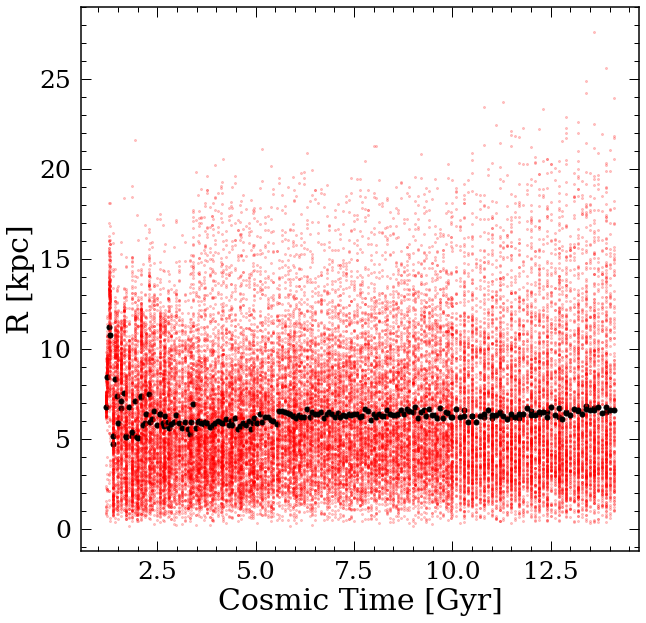

In [43]:

colors = getcolor(allages_rs)
plt.figure()
for i in range(len(sortage)):
    try:
        stars['r_'+str(sortage[i])]
    except:
        print('no radius!')
        continue
    plt.plot(allages_rs[i]*np.ones(len(stars['r_'+str(sortage[i])])), stars['r_'+str(sortage[i])], 
             'ro', markersize=2, alpha=0.2)
    plt.plot(allages_rs[i], np.mean(stars['r_'+str(sortage[i])]), 
             'ko', markersize=5, label='mean R')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('R [kpc]')
    
        

In [45]:
len(times), len(allages_rs)

(206, 229)

Text(0, 0.5, '$σ_{ΔR}$')

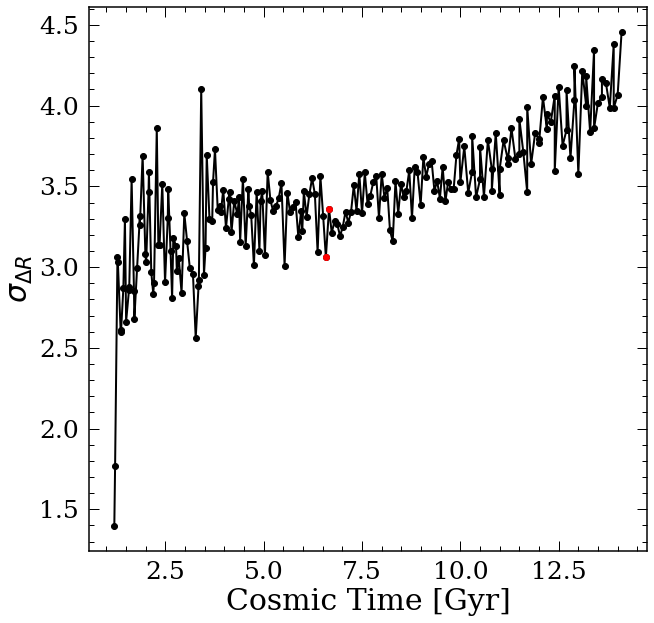

In [89]:

times, sigmars = np.array(times, dtype=float), np.array(sigmars, dtype=float)
plt.plot(times, sigmars, 'k-o')
plt.plot(times[100], sigmars[100], 'ro')
plt.plot(times[99], sigmars[99], 'ro')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('$σ_{ΔR}$')


Text(0, 0.5, '$mean_{ΔR}$')

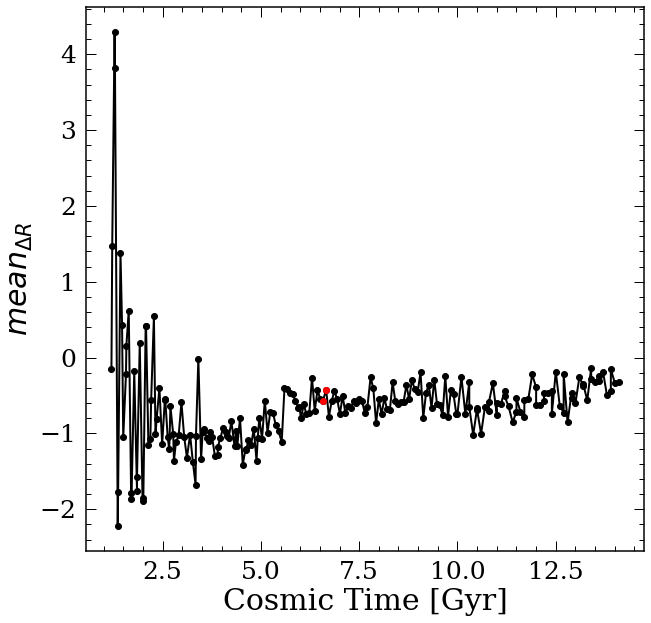

In [90]:

times, sigmars_mean = np.array(times, dtype=float), np.array(sigmars_mean, dtype=float)
plt.plot(times, sigmars_mean, 'k-o')
plt.plot(times[100], sigmars_mean[100], 'ro')
plt.plot(times[99], sigmars_mean[99], 'ro')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('$mean_{ΔR}$')



3.3622246108142293
3.0612859741850684


Text(0.5, 0, '$R$-$R_{bir}$')

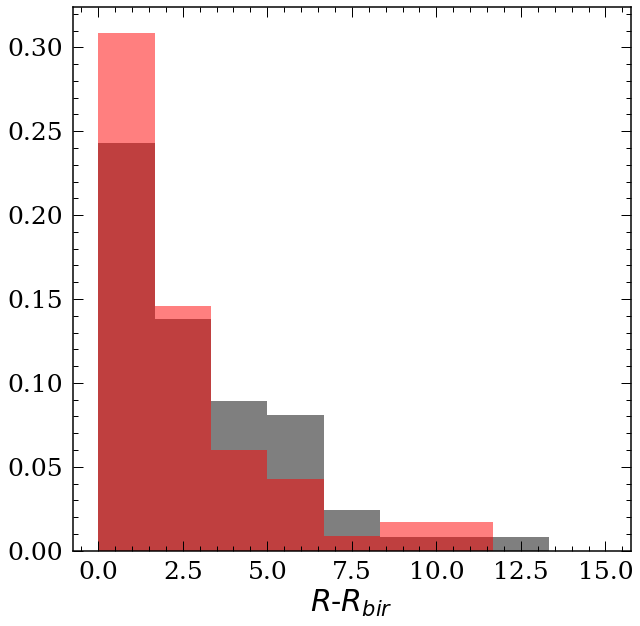

In [92]:

m = (allages_rs == times[100])
"""
plt.plot((stars['r_'+str(np.array(sortage)[m][0])]-stars['Rbir']), 
np.zeros(len(stars['r_'+str(np.array(sortage)[m][0])])), 
             'ro', markersize=2)
"""
plt.hist(stars['r_'+str(np.array(sortage)[m][0])]-stars['Rbir'], 
         density=True, color='k', bins=np.linspace(0,15,10),
        alpha=0.5);
print(np.std((stars['r_'+str(np.array(sortage)[m][0])]-stars['Rbir'])))

m = (allages_rs == times[99])
"""
plt.plot(stars['r_'+str(np.array(sortage)[m][0])]-stars['Rbir'], 
         np.zeros(len(stars['r_'+str(np.array(sortage)[m][0])])), 
             'ro', markersize=2)
"""
plt.hist(stars['r_'+str(np.array(sortage)[m][0])]-stars['Rbir'], 
         density=True, color='r', bins=np.linspace(0,15,10),
        alpha=0.5);
print(np.std(stars['r_'+str(np.array(sortage)[m][0])]-stars['Rbir']))
plt.xlabel('$R$-$R_{bir}$')
#plt.ylim([-0.2,0.55])

In [78]:
len(stars['r_'+str(np.array(sortage)[m][0])])

190

3.3668340260989043
3.059519878443134


Text(0.5, 0, 'R')

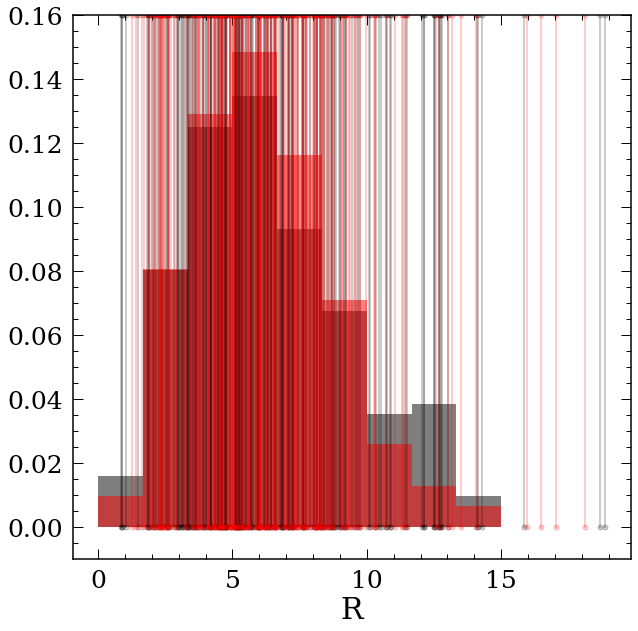

In [93]:

m = (allages_rs == times[100])

for i in range(len(stars['r_'+str(np.array(sortage)[m][0])])):
    plt.plot([(stars['r_'+str(np.array(sortage)[m][0])]).values[i],
              (stars['r_'+str(np.array(sortage)[m][0])]).values[i]], 
             [0,0.16], 'ko-', markersize=5, alpha=0.2)
plt.hist(stars['r_'+str(np.array(sortage)[m][0])], 
         density=True, color='k', bins=np.linspace(0,15,10),
        alpha=0.5);
print(np.std((stars['r_'+str(np.array(sortage)[m][0])])))


m = (allages_rs == times[99])
for i in range(len(stars['r_'+str(np.array(sortage)[m][0])])):
    plt.plot([(stars['r_'+str(np.array(sortage)[m][0])]).values[i],
              (stars['r_'+str(np.array(sortage)[m][0])]).values[i]], 
             [0,0.16], 'ro-', markersize=5, alpha=0.2)
plt.hist(stars['r_'+str(np.array(sortage)[m][0])], 
         density=True, color='r', bins=np.linspace(0,15,10),
        alpha=0.5);
print(np.std(stars['r_'+str(np.array(sortage)[m][0])]))

plt.ylim([-0.01,0.16])
plt.xlabel('R')